# Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, we will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, the code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling. 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, we will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Our imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Importing the packages
import os
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torchsummary import summary
from PIL import ImageFile, Image
from utils.model import resnet_model, BaselineModel     # module containing model architectures
from utils.detector import dog_detector, detect_face   # loads the dog and face detectors
import main      # checks the perfomance for various detectors and provides other important attributes

ImageFile.LOAD_TRUNCATED_IMAGES = True

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  The path to find these detectors are a little tricky but it is provided in `detector.py` module of `detector` package.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


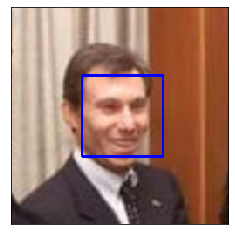

In [5]:
image_path = main.human_files[0]
detect_face(image_path)

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

### (IMPLEMENTATION) Assess the Human Face Detector's performance

In [6]:
# loading the detector and images
detector = main.face_detector
dog_images_ = main.dog_files_short    # loads first 100 dog images
human_images = main.human_files_short # loads first 100 human images
main.test_performance(detector, human_images, dog_images_)

100%|██████████| 100/100 [00:16<00:00,  6.03it/s]

First 100 images in human_files have 99.0% human detected.
First 100 images in dog_files have 18.0% human detected.


### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

__Answer:__
- First 100 images in `human_files` have 99.0% human face detected.
- First 100 images in `dog_files` have 18.0% human face detected.

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  We saw that our algorithm falls short of this goal, but still gives acceptable performance.  We extracted the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short` and loaded them.

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

Although it might seem tempting to ask user to provide a clear view of the face, but it will be on the cost of lack of flexibility and robustness of our app. We might get around it (_to some extent_) is to use various data augmentation techniques and more superior face detection algorithms which make use of deep learning. The webapp would still not be perfect though but it will be far more improved.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained ResNet-50 Model

The code cell below downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In the backend, we have a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained ResNet-50 model.  The output should always be an integer between 0 and 999, inclusive.

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we noticed that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Using these ideas we completed the `dog_detector` function, which returns `True` if a dog is detected in an image (and `False` if not).

In [7]:
# changing the detector to dog-detector
detector = main.dog_detector
main.test_performance(detector, human_images, dog_images_)

100%|██████████| 100/100 [01:29<00:00,  1.11it/s]

First 100 images in human_files have 0.0% dog detected.
First 100 images in dog_files have 97.0% dog detected.


### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__

- Images in`human_files_short` have 0% dogs detected.
- Images in `dog_files_short` have 97% dogs detected.

<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds. In Step 4 of this notebook, we will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black. Our vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Specifying Data Loaders and Augmentation

Using the various data augmentation techniques involving Resizing the image and then center cropping to make the image suitable for the input. Randomly flipping the images horizontally and adding color jitter since the images can vary in terms of brightness, contrast etc. to avoid the overfitting. Scaling the image (mean=0, std=1) according to the ImageNet Stats is also required to be done on the images. After applying data augmentation, the three datasets are divided in small batches using `DataLoader` class.

In [8]:
# Write data loaders for training, validation, and test sets
# Specify appropriate transforms, and batch_sizes
batch_size = 32
data_dir = 'dog_images/'

# defining the train, valid and test directories
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# Normalizing the images with ImageNet dataset
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# Defining the transforms
train_transform = transforms.Compose([transforms.Resize(256),     
                                      transforms.CenterCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.2, 
                                                             contrast=0.2, 
                                                             saturation=0.2, 
                                                             hue=0.1),
                                      transforms.ToTensor(),
                                      normalize])
# transforms for validation and test datasets
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                normalize])

# defining the train, valid and test data
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

# creating the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          shuffle=True)

loaders = {"train": train_loader,
           "valid": valid_loader,
           "test": test_loader}

In [9]:
# Calculating the number of classes
num_classes = len(train_data.classes)
num_classes

133

In [10]:
# check if GPU is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [12]:
# Instantiate the baseline CNN
model_scratch = BaselineModel()

# Move the model to GPU
if use_cuda:
    model_scratch.cuda()

print(model_scratch)
# Checking out the summary of the model
summary(model_scratch, (3, 224, 224))

BaselineModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=168, bias=True)
  (fc2): Linear(in_features=168, out_features=133, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             448
         MaxPool2d-2         [-1, 16, 111, 111]               0
            Conv2d-3         [-1, 32, 109, 109]           4,640
         MaxPool2d-4           [-1, 32, 54, 54]               0
            Conv2d-5           [-1

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

- My final CNN architecture consists of 5 convolutional layers with increasing number of filters in subsequent layers. This is a very common practice which is there in almost all state of the art models of convolutional neural networks. The reason for that is as we move forward in the network we have increasingly complex patterns. For example, first few layers would capture edges, lines, etc., layers after them would capture different shapes which are formed of patterns understood in  previous layers. So we increasingly need more filters to capture those complex patterns
- With increasing number of filters in the subsequent layers, we are also downsizing our filters so as to accomodate the number of categories to predict. This is done by adding maxpooling layers
- The last layer two layers are fully connected which have hidden units as the number of categories to be predicted
- To avoid overfitting we add dropout layers in fully connected layers

In [ ]:
# select loss function
criterion_scratch = nn.NLLLoss()

learning_rate = 0.001
# select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=learning_rate, 
                               weight_decay=5e-4)
# adding a learning rate scheduler
scheduler_scratch = optim.lr_scheduler.ReduceLROnPlateau(optimizer_scratch, 'min', 
                                                 verbose = True, factor = 0.6, 
                                                 patience = 8)

#### Training the model

In [11]:
# function to train the model
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, scheduler=None):
    """returns trained model"""
    # Time everything
    start_time = time.time()
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    for epoch in range(1, n_epochs+1):
        # Time to run each epoch
        epoch_start_time = time.time() 
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            # clearing the optimizer
            optimizer.zero_grad()
            
            # feed forward
            output = model(data)
            
            # calculate the loss
            loss = criterion(output, target)
            
            # backprop
            loss.backward()
            
            # optimizer step
            optimizer.step()
            
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += (1 / (batch_idx + 1)) * (loss.data - train_loss)
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            
            loss = criterion(output, target)
            
            valid_loss += (1 / (batch_idx + 1)) * (loss.data - valid_loss)
        if scheduler is not None:
            scheduler.step(valid_loss)
        # print training/validation statistics 
        print('Epoch: {} done in {:.2f} seconds.\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            time.time() - epoch_start_time,
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model ... ".format(
            valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    print("Training finished in {:.2f} seconds".format(time.time() - start_time))
    # return trained model
    return model

In [15]:
# train the model
model_scratch = train(50, loaders, model_scratch, optimizer_scratch, 
                        criterion_scratch, use_cuda, 'model_scratch.pt', 
                      scheduler_scratch)

Epoch: 1 done in 134.87 seconds.	Training Loss: 4.886255 	Validation Loss: 4.872089
Validation loss decreased (inf --> 4.872089). Saving model ... 
Epoch: 2 done in 134.90 seconds.	Training Loss: 4.873092 	Validation Loss: 4.862581
Validation loss decreased (4.872089 --> 4.862581). Saving model ... 
Epoch: 3 done in 135.40 seconds.	Training Loss: 4.766386 	Validation Loss: 4.625907
Validation loss decreased (4.862581 --> 4.625907). Saving model ... 
Epoch: 4 done in 135.37 seconds.	Training Loss: 4.630713 	Validation Loss: 4.564723
Validation loss decreased (4.625907 --> 4.564723). Saving model ... 
Epoch: 5 done in 135.09 seconds.	Training Loss: 4.572158 	Validation Loss: 4.519475
Validation loss decreased (4.564723 --> 4.519475). Saving model ... 
Epoch: 6 done in 135.54 seconds.	Training Loss: 4.517683 	Validation Loss: 4.443215
Validation loss decreased (4.519475 --> 4.443215). Saving model ... 
Epoch: 7 done in 135.71 seconds.	Training Loss: 4.472004 	Validation Loss: 4.411332
Val

#### Testing the model

In [12]:
# function to test the trained model
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [17]:
# load the model that got the best validation accuracy for model_scratch
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

# call test function    
test(loaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.842871


Test Accuracy: 13% (109/836)


Our CNN model from scratch performed pretty poorly with only 13% test accuracy. This was expected since classifying dog breeds is a challenging task. Also, our model from the scratch was quite a simple model which we only treated as a baseline model. Now, we know which direction should we go.

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset
We'll use the same data loaders from the previous step, when we created a CNN from scratch.

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

- We used __ResNet50__ as the architecture for my transfer learning network. It is a go-to network for basic image classification tasks and is trained on __ImageNet__ data which includes 118 different breeds of the dogs. We chose ResNet50 over VGG16 (_used by Udacity_) because it is faster to train with much less trainable parameters as compared to __VGG16__. One important thing to notice that ImageNet dataset has 1000 output classes and in our case, we have 133 different breeds of the dogs. Because of this we needed to change the `out_features` of the `fc` layer of the ResNet50.

- In our case, since the ImageNet datasets has already images of dog breeds and we don't have enough images of dogs. We will do [__feature extraction__](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html), where we will start with a pretrained model and only update the final layer weights from which we derive predictions. 

- For the last `fc` layer, I initialized the weights by [`kaiming_normal_`](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_) to have faster convergence and better accuracy.

In [13]:
model_transfer = resnet_model(use_cuda)

for params in model_transfer.parameters():
    params.requires_grad = False

print(model_transfer.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [14]:
# Replacing the last layer (by default it will have requires_grad == True)
model_transfer.fc = nn.Linear(model_transfer.fc.in_features,num_classes)

In [19]:
# Initializng the weights
nn.init.kaiming_normal_(model_transfer.fc.weight)

Parameter containing:
tensor([[-0.0067,  0.0602,  0.0289,  ..., -0.0008,  0.0010,  0.0133],
        [ 0.0745,  0.0447,  0.0025,  ...,  0.0352,  0.0529, -0.0130],
        [-0.0398,  0.0080, -0.0154,  ..., -0.0324,  0.0257, -0.0457],
        ...,
        [ 0.0007, -0.0315,  0.0018,  ...,  0.0027, -0.0200, -0.0195],
        [-0.0568,  0.0304,  0.0032,  ..., -0.0147, -0.0052, -0.0275],
        [-0.0035,  0.0021, -0.0374,  ..., -0.0268, -0.0104, -0.0044]],
       requires_grad=True)

In [15]:
print(model_transfer.fc)
if use_cuda:
    model_transfer.cuda()

Linear(in_features=2048, out_features=133, bias=True)


In [16]:
### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
loaders_transfer = loaders

In [20]:
### Select loss function
criterion_transfer = nn.CrossEntropyLoss()

learning_rate = 3e-4
### Select optimizer
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=learning_rate, 
                               weight_decay=5e-4)
scheduler_transfer = optim.lr_scheduler.ReduceLROnPlateau(optimizer_transfer, 'min', 
                                                 verbose = True, factor = 0.6, 
                                                 patience = 7)

In [30]:
# train the model
model_transfer = train(50, loaders_transfer, model_transfer, optimizer_transfer, 
                       criterion_transfer, use_cuda, 'model_transfer.pt', scheduler_transfer)

Epoch: 1 done in 126.80 seconds.	Training Loss: 3.310377 	Validation Loss: 1.774062
Validation loss decreased (inf --> 1.774062). Saving model ... 
Epoch: 2 done in 126.46 seconds.	Training Loss: 1.473104 	Validation Loss: 1.040349
Validation loss decreased (1.774062 --> 1.040349). Saving model ... 
Epoch: 3 done in 126.72 seconds.	Training Loss: 0.968785 	Validation Loss: 0.755697
Validation loss decreased (1.040349 --> 0.755697). Saving model ... 
Epoch: 4 done in 126.26 seconds.	Training Loss: 0.758659 	Validation Loss: 0.668859
Validation loss decreased (0.755697 --> 0.668859). Saving model ... 
Epoch: 5 done in 126.27 seconds.	Training Loss: 0.644567 	Validation Loss: 0.570754
Validation loss decreased (0.668859 --> 0.570754). Saving model ... 
Epoch: 6 done in 126.41 seconds.	Training Loss: 0.557755 	Validation Loss: 0.596792
Epoch: 7 done in 125.85 seconds.	Training Loss: 0.495526 	Validation Loss: 0.538046
Validation loss decreased (0.570754 --> 0.538046). Saving model ... 
Epo

In [21]:
 # load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location={'cuda:0':'cpu'}))

test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.387118


Test Accuracy: 88% (740/836)


In [45]:
def show_image_from_path(img_path, shape=None, title=None):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    if shape is not None:
        img = cv2.resize(img, shape)
    plt.imshow(img)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    if title is not None:
        plt.gca().set_title(title)
    plt.show()

Briard


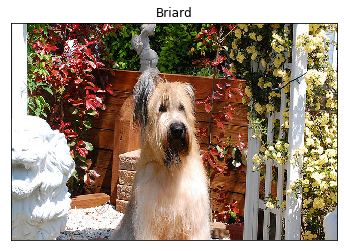

In [46]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path, model, use_cuda):
    # load the image and return the predicted breed
    image = Image.open(img_path).convert('RGB')
    
    in_transform = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        normalize])
    image = in_transform(image)
    image = torch.unsqueeze(image, 0)
    if use_cuda:
        image = image.cuda()
        model.cuda()
    model.eval()
    output = model(image)
    probas = F.softmax(output, 1).to("cpu")
    index = torch.argmax(output, dim=1).to("cpu")
    return index.detach().numpy()[0], probas.detach().numpy()[0]

test_image = main.dog_files_short[37]
pred, probs = predict_breed_transfer(test_image, model_transfer, use_cuda)
print(class_names[pred])
show_image_from_path(test_image, title = class_names[pred])

<a id='step5'></a>
## Step 5: Writing the Algorithm

In this step, we will write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

We'll use the `face_detector` and `human_detector` functions developed before.  We'll also be using our CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write the Algorithm

In [47]:
dog_dirs = os.listdir(train_dir)
def similar_dog(breed_name, dog_directory=None, shape=None):
    if len(breed_name.split()) > 1:
        breed = breed_name.replace(" ", "_")
    else:
        breed = breed_name
    for dog_dir in dog_directory:
        if dog_dir.split('.')[1] == breed:
            path = os.path.join(train_dir, dog_dir)
            dog_image = os.listdir(path)[0]
            img_path = path + '/' + dog_image
            show_image_from_path(img_path, shape, title=breed_name)

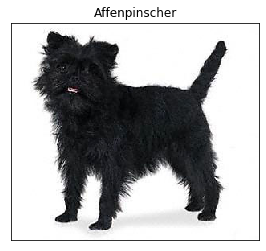

In [48]:
similar_dog('Affenpinscher', dog_dirs)

In [52]:
### TODO: Write your algorithm.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if dog_detector(img_path, use_cuda=use_cuda)[0]:
        idx, _ = predict_breed_transfer(img_path, model_transfer, use_cuda)
        img_title = "This cutie looks like a ...\n{}".format(class_names[idx])
        plt.figure(figsize=(6, 6))
        show_image_from_path(img_path, title = img_title)
    elif main.face_detector(img_path)[0]:
        img = Image.open(img_path)
        img_shape = img.size
        idx, _ = predict_breed_transfer(img_path, model_transfer, use_cuda)
        img_title = "Hello, human! \n You look like a ...\n{}".format(class_names[idx])
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(121)
        show_image_from_path(img_path, title=img_title)
        ax = fig.add_subplot(122)
        similar_dog(class_names[idx], dog_dirs, shape=img_shape)
    else:
        print("It's neither a dog nor a human, check your image!")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, we will take your new algorithm for a spin!  What kind of dog does the algorithm think that _a person_ looks like?  If we have a dog, does it predict our dog's breed accurately?  If we have a cat, does it mistakenly think that our cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

As already mentioned, predicting dog breeds is a challenging task. Just by plain guessing we have less then 1% (1/133) chance to predict the dog breed correctly. So keeping that in mind our model trained using transfer learning performed better than I expected with a 88% test accuracy. There are, however, some avenues for further improvement:
- Have a larger dataset, neural networks are data hungry and their performance depends a lot on the volume of data we have
- Try different data augmentation techniques like random rotation, 10-crop, etc. These will account for the different pose and zoom levels
- Tune hyperparameters like learning rate, batch size and number of epochs to find the best combinations of these parameters
- Try another bigger models like Inception, Densenets (_This might not work since we have limited data_)

----------------------------------------------------------------------------------------------------


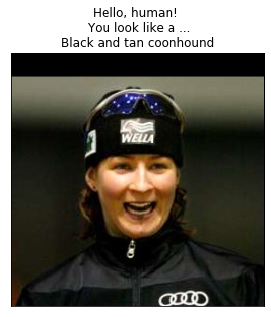

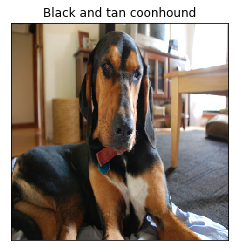

----------------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

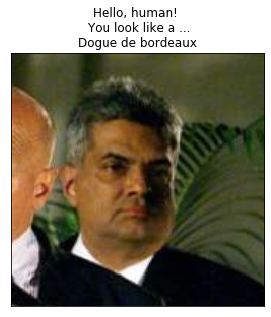

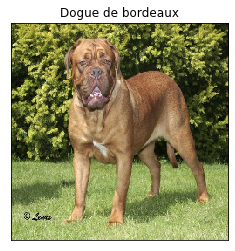

----------------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

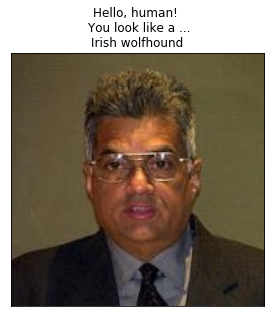

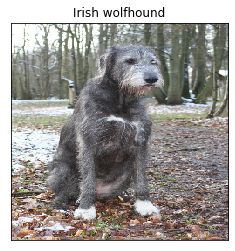

----------------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

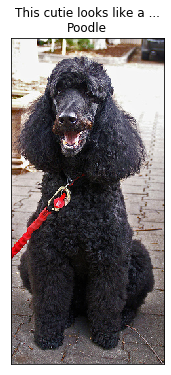

----------------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

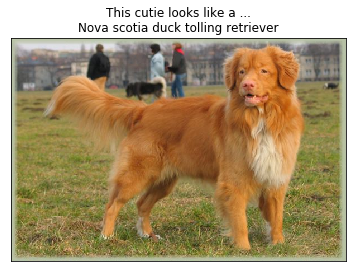

----------------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

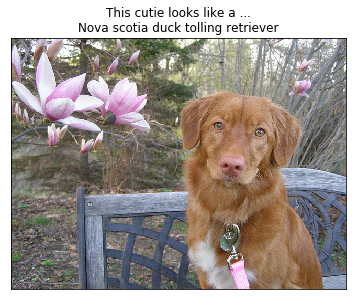

<Figure size 432x288 with 0 Axes>

In [54]:
for file in np.hstack((main.human_files[15:18], main.dog_files[15:18])):
    print('-'*100)
    run_app(file)